# ニューラルネットワークの実装と手書き数字の認識

ニューラルネットワークによる機械学習の原理を理解するとともに勾配法や自然勾配法の実装をし，手書き数字の認識を行う．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

## ニューラルネットワークの学習原理と実装

### 仮説とコスト関数の計算：順伝播

特徴量ベクトルを$\vec{x} =(x_1 ,\dots ,x_n)^\mathrm{T}$，ターゲットの1-hot表現を$\vec{y} =(y_1 ,\dots ,y_C)^\mathrm{T}$とする．1-hot表現$\vec{y}$は$C$次元ベクトルであり，クラスのラベルが$c$ならば$\vec{y}$は第$c$成分のみ1で他が0のベクトルとなる．特徴量$\vec{x}$とターゲット$\vec{y}$は何らかの真の分布$p(\vec{x} ,\vec{y})=p(\vec{x})p(\vec{y} \vert\vec{x})$に従う．

ニューラルネットワークを用いて分布$p(\vec{y} \vert\vec{x})$を推定したい．$L+1$層のニューラルネットワークは次のように与えられる：
\begin{align}
& \vec{a}^{(0)} =\vec{x} , \\
& \left\{
\begin{aligned}
& a_0^{(l)} =1,\quad a^{(l)} =
\begin{pmatrix}
a_0^{(l)} \\
\vec{a}^{(l)}
\end{pmatrix}
, \\
& (\vec{z}^{(l+1)})^\mathrm{T} =(a^{(l)})^\mathrm{T} \Theta ^{(l)} , \\
& \vec{a}^{(l+1)} =\vec{\phi}^{(l+1)} (\vec{z}^{(l+1)})
\end{aligned}
\right.\quad (l=0,\dotsc,L-1), \\
& \vec{h} (\vec{x} \vert\Theta )=\vec{a}^{(L)} .
\end{align}
$l$は層の番号を表し，$l=0$は入力層，$l=1,\dots ,L-1$は隠れ層，$l=L$は出力層である．入力変数は特徴量ベクトル$\vec{x} =(x_1 ,\dots ,x_n)^\mathrm{T}$であり，出力変数は仮説$\vec{h} (\vec{x} \vert\Theta )=(h_1 (\vec{x} \vert\Theta ) ,\dots ,h_C (\vec{x} \vert\Theta ))^\mathrm{T}$である．パラメータ$\Theta$は$L$個の行列（重み）$\Theta ^{(l)}$から成る：$\Theta =(\Theta ^{(l)})_{l=0,1,\dots ,L-1}$. 第$l$層には$n_l$次元変数$\vec{a}^{(l)} =(a_1^{(l)} ,\dots ,a_{n_l}^{(l)})^\mathrm{T}$が割り当てられている．定義から$n_0 =n$, $n_L =C$である．中括弧で括られた漸化式は第$l$層の変数$\vec{a}^{(l)}$から第$l+1$層の変数$\vec{a}^{(l+1)}$への変換を示しており，漸化式を次々に計算する過程は順伝播と呼ばれる．漸化式の第1式は$\vec{a}^{(l)}$に0番目の成分$a_0^{(l)} =1$を加える操作であり，その結果を$a^{(l)}$とする（成分のインデックスが1から始まるベクトルは矢印をつけて表し，インデックスが0から始まるベクトルには矢印をつけない）．第2式は$(n_l +1)\times n_{l+1}$行列$\Theta ^{(l)} =({\Theta ^{(l)\mu}}_j)_{\mu =0,1,\dots ,n_l ;j=1,\dots ,n_{l+1}}$（アルファベット$i,j,\dots$は1から始まる（0を含まない）添字，ギリシャ文字$\mu ,\nu ,\dots$は0から始まる添字とする）をかける線形変換であり，その結果を$\vec{z}^{(l+1)} =(z_1^{(l+1)} ,\dots ,z_{n_{l+1}}^{(l+1)})^\mathrm{T}$とする．第3式は$\vec{z}^{(l+1)}$に活性化関数$\vec{\phi}^{(l+1)} =(\phi _1^{(l+1)} ,\dots ,\phi _{n_{l+1}}^{(l+1)})^\mathrm{T}$を作用させる操作であり，その結果が第$l+1$層の変数$\vec{a}^{(l+1)}$である．

隠れ層$l=1,\dots ,L-1$の活性化関数$\vec{\phi}^{(l)}$はすべての隠れ層について同じ関数$\phi$とし，引数の成分ごとに作用するとする：
$$
\phi _i^{(l)} (\vec{z})=\phi (z_i)\quad (l=1,\dots ,L-1).
$$
隠れ層の活性化関数$\phi$はシグモイド関数
$$
\phi (z)=\frac{1}{1+e^{-z}}
$$
やReLU関数
$$
\phi (z)=\max\{ z,0\}
$$
にとることが多い．一方，出力層$l=L$の活性化関数$\vec{\phi}^{(L)}$はソフトマックス関数$\vec{S} =(S_1 ,\dots ,S_C)^\mathrm{T}$とする：
$$
\phi _c^{(L)} (\vec{z})=S_c (\vec{z})=\frac{e^{z_c}}{\sum _{d=1}^C e^{z_d}} .
$$

重みが$\Theta$であるとき，特徴量$\vec{x}$に対してターゲットが$\vec{y}$となる確率が次のように与えられると推定しよう：
$$
p(\vec{y} \vert\vec{x} ,\Theta )=\prod _{c=1}^C h_c (\vec{x} \vert\Theta )^{y_c} .
$$
すなわち，ターゲット$\vec{y}$のクラスが$c$である確率が$h_c (\vec{x} \vert\Theta )$である．したがって，仮説$\vec{h} (\vec{x} \vert\Theta )$はターゲットのクラスに関する確率ベクトルとなっている．上式の分布は規格化条件
$$
\sum _{\vec{y} =(1,0,\dots ,0)^\mathrm{T} ,(0,1,0,\dots ,0)^\mathrm{T} ,\dots ,(0,\dots ,0,1)^\mathrm{T}} p(\vec{y} \vert\vec{x} ,\Theta )=1
$$
を満たす．実際には$h_\Theta (\vec{x})$の成分が最も大きくなるようなインデックス$c$がデータの属するクラスであると予測する．

コスト関数$J(\Theta )$は，2つの分布$p(\vec{y} \vert\vec{x})$, $p(\vec{y} \vert\vec{x} ,\Theta )$の条件付きKullback-Leipler (KL) ダイバージェンス
$$
\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\log\frac{p(\vec{y} \vert\vec{x})}{p(\vec{y} \vert\vec{x} ,\Theta )} \right] =\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x})]-\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x} ,\Theta )]
$$
から第1項の定数を除いたもの，すなわち交差エントロピーとする：
$$
J(\Theta )=-\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x} ,\Theta )]=-\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\sum _{c=1}^C y_c \log h_c (\vec{x} \vert\Theta )\right] .
$$

### コスト関数の勾配計算：誤差逆伝播法

次にコスト関数の勾配
$$
\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} =\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\frac{\partial}{\partial {(\Theta ^{(l)})^\mu}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))\right]
$$
を求めよう．偏微分の連鎖率を用いると，対数尤度関数の勾配は次のように表される：
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial {\Theta ^{(l)\mu}}_j} \left(\prod _{l'=l+1}^{L-1} \frac{\partial a_{i_{l'}}^{(l')}}{\partial z_{j_{l'}}^{(l')}} \frac{\partial z_{j_{l'+1}}^{(l'+1)}}{\partial a_{i_{l'}}^{(l')}} \right)\frac{\partial a_{i_L}^{(L)}}{\partial z_{j_L}^{(L)}} \frac{\partial}{\partial a_{i_L}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta )).
$$
ただし，$l'=l+1,\dots ,L-1$に関する積は$l=L-1$のとき1とする．また，2回繰り返された添字（上式では$i_{l+1} \dots ,i_L$, $j_{l+1} ,\dots ,j_L$）について和をとるEinsteinの縮約規則を用いた．ここで
$$
\delta ^{(l+1)j_{l+1}} =\frac{\partial}{\partial z_{j_{l+1}}^{(l+1)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\left(\prod _{l'=l+1}^{L-1} \frac{\partial a_{i_{l'}}^{(l')}}{\partial z_{j_{l'}}^{(l')}} \frac{\partial z_{j_{l'+1}}^{(l'+1)}}{\partial a_{i_{l'}}^{(l')}} \right)\frac{\partial a_{i_L}^{(L)}}{\partial z_{j_L}^{(L)}} \frac{\partial}{\partial a_{i_L}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))
$$
とおくと，次式が得られる：
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial {\Theta ^{(l)\mu}}_j} \delta ^{(l+1)j_{l+1}} =a_\mu ^{(l)} \delta ^{(l+1)j} .
$$

$\vec{\delta}^{(l)} =(\delta ^{(l)1} ,\dots ,\delta ^{(l)n_l})^\mathrm{T}$ ($l=1,\dots ,L$) は「誤差」と呼ばれる．出力層$l=L$の誤差ベクトル$\vec{\delta}^{(L)}$は仮説とターゲットの差となる：
\begin{align}
\delta ^{(L)c} & =\frac{\partial}{\partial z_c^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial a_{c'}^{(L)}}{\partial z_c^{(L)}} \frac{\partial}{\partial a_{c'}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta )) \\
& =-\sum _{c'=1}^C \frac{y_{c'}}{a_{c'}^{(L)}} a_{c'}^{(L)} (\delta _{c'c} -a_c^{(L)})=\sum _{c'=1}^C y_{c'} (a_c^{(L)} -\delta _{c'c}) \\
& =a_c^{(L)} -y_c \\
\iff\vec{\delta}^{(L)} & =\vec{a}^{(L)} -\vec{y} .
\end{align}
ここでKroneckerのデルタを$\delta _{c'c}$と書いた．また，隠れ層$l=1,\dots ,L-1$の誤差ベクトル$\vec{\delta}^{(l)}$は次の漸化式から計算できる：
$$
\delta ^{(l)j_l} =\frac{\partial a_{i_l}^{(l)}}{\partial z_{j_l}^{(l)}} \frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial a_{i_l}^{(l)}} \delta ^{(l+1)j_{l+1}} =\frac{\partial\phi _{i_l}^{(l)} (\vec{z}^{(l)})}{\partial z_{j_l}^{(l)}} {\Theta ^{(l)i_l}}_{j_{l+1}} \delta ^{(l+1)j_{l+1}} \iff\vec{\delta}^{(l)} =\sigma '(\vec{z}^{(l)})*(\tilde{\Theta}^{(l)} \vec{\delta} ^{(l+1)}).
$$
ここで，$\sigma '(\vec{z}^{(l)})$は$\vec{z}^{(l)}$の各成分を引数に持つシグモイド関数$\sigma$の導関数であり，シグモイド関数$\sigma$の導関数は次のように与えられる：
$$
\sigma '(z)=\sigma (z)(1-\sigma (z)).
$$
また，$\tilde{\Theta}^{(l)} =({\Theta ^{(l)i}}_j)_{i=1,\dots ,n_l;j=1,\dots ,n_{l+1}}$は$\Theta ^{(l)}$から第0行を除いて得られる行列であり，$*$はベクトルの成分ごとの積を表す．

以上で導いた式を用いてコスト関数の勾配を計算することができる．上の$\vec{\delta}^{(l)}$に関する漸化式は誤差を出力層から入力に近い層に向かって逆に伝播させる過程と見なせるため，逆伝播と呼ばれる．また，このように誤差やコスト関数の勾配を求める方法は誤差逆伝播法と呼ばれる．

### 誤差逆伝播法の転送行列を用いた定式化

誤差ベクトルの逆伝播は以下のように転送行列を用いても定式化できる．隠れ層$l=1,\dots ,L-1$に対して転送行列$t^{(l)} =({t^{(l)j_l}}_{j_{l+1}})_{j_l =1,\dots ,n_l ;j_{l+1} =1,\dots ,n_{l+1}}$を
$$
{t^{(l)j_l}}_{j_{l+1}} =\frac{\partial\phi _{i_l}^{(l)} (\vec{z}^{(l)})}{\partial z_{j_l}^{(l)}} {\Theta ^{(l)i_l}}_{j_{l+1}} .
$$
により定義する．さらに，第$l'$層から第$l$層への累積転送行列$T^{(l,l')} =({T^{(l,l')j_l}}_{j_{l'}})_{j_l =1,\dots ,n_l ;j_{l'} =1,\dots ,n_{l'}}$を
$$
{T^{(l,l')j_l}}_{j_{l'}} = {t^{(l)j_l}}_{j_{l+1}} \cdots {t^{(l'-1)j_{l'-1}}}_{j_{l'}} \iff T^{(l,l')} =t^{(l)} \cdots t^{(l'-1)}
$$
により定義する．ただし，$l=l'$のときは${T^{(l,l')j_l}}_{j_{l'}} =\delta _{j_{l'}}^{j_l}$（Kroneckerのデルタ）とする．このとき，
$$
\delta ^{(l)j} = {T^{(l,L)j}}_c \delta ^{(L)c} \iff\vec{\delta}^{(l)} =T^{(l,L)} \vec{\delta}^{(L)}
$$
が成り立つ．したがって，出力層の誤差ベクトル$\vec{\delta}^{(L)}$に出力層から第$l$層への累積転送行列$T^{(l,L)}$かけることで，第$l$層の誤差ベクトル$\vec{\delta}^{(l)}$が求まる．また，漸化式
$$
T^{(l,L)} =t^{(l)} T^{(l+1,L)} .
$$
に注目すると，転送行列$t^{(l)}$は第$l+1$層から第$l$層へ誤差を転送する行列であることがわかる．よって，あらかじめ局所的な転送行列の組$t=(t^{(l)})_{l=1,\dots ,L-1}$および出力層から隠れ層への累積転送行列の組$T=(T^{(l,L)})_{l=1,\dots ,L}$を計算しておき，後から各層の誤差ベクトルを求めることができる．この計算法は後述する自然勾配法の実行のために便利である．

### 正則化および最大事後確率推定との関係

実際の計算では真の分布$p(x,y)$がわからないため，期待値$\mathrm{E}_{p(x,y)} [\cdot ]$は訓練データに関する平均値に置き換える：
\begin{align}
J(\Theta ) & =-\frac{1}{D} \sum _{d=1}^D \log p(\vec{y}^{[d]} \vert\vec{x}^{[d]} ,\Theta ), \\
\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} & =-\frac{1}{D} \sum _{d=1}^D \frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} \log p(\vec{y}^{[d]} \vert\vec{x}^{[d]} ,\Theta ).
\end{align}
ここで，$[d]$ ($d=1,\dots ,D$) は訓練データのインデックスを表す．

正則化を行う場合，コスト関数とその勾配は次のように表される：
\begin{align}
J_\mathrm{r} (\Theta ) & =J(\Theta )+\frac{1}{2D} \sum _{l=0}^{L-1} \sum _{\mu =0}^{n_l} \sum _{j=1}^{n_{l+1}} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 , \\
\frac{\partial J_\mathrm{r} (\Theta )}{\partial {\Theta ^{(l)\mu}}_j} & =\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} +\frac{1}{D} {M^{(l)\mu}}_j {\Theta ^{(l)\mu}}_j .
\end{align}
正則化パラメータ$M=(M^{(l)})_{l=0,1,\dots ,L-1} =({M^{(l)\mu}}_j)_{l=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;j=1,\dots ,n_{l+1}}$はハイパーパラメータである．正則化項をつけたコスト関数$J_\mathrm{r} (\Theta )$の最小化は，与えられたデータ$\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} _{d=1,\dots ,D}$とハイパーパラメータ$M$に対して事後分布$p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)$を最大化するパラメータ$\Theta$の推定，すなわち最大事後確率推定と見なせる．実際，各データが独立同分布$p(\vec{x} ,\vec{y})$に従って生成されると仮定すると，
$$
p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)=\frac{p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,\Theta\vert M)}{p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} )}
$$
および
$$
p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,\Theta\vert M)=p(\Theta\vert M)p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} \vert\Theta )=p(\Theta\vert M)\prod _{d=1}^D p(\vec{x}^{[d]} ,\vec{y}^{[d]} \vert\Theta )
$$
が成り立つので，ハイパーパラメータ$M$に対するパラメータ$\Theta$の分布を正規分布
$$
p(\Theta\vert M)=\prod _{l=0}^{L-1} \prod _{\mu =0}^{n_l} \prod _{j=1}^{n_{l+1}} \sqrt{\frac{{M^{(l)\mu}}_j}{2\pi}} \exp\left( -\frac{1}{2} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 \right)
$$
とすると，
$$
\mathop{\mathrm{arg\, max}}_\Theta p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)=\mathop{\mathrm{arg\, max}}_\Theta J_\mathrm{r} (\Theta )
$$
が導かれる．なお，正則化なしのコスト関数の最小化は尤度関数$p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\}\vert\Theta )$を最大化するパラメータ$\Theta$の推定，すなわち最尤推定と見なせる：
$$
\mathop{\mathrm{arg\, max}}_\Theta p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\}\vert\Theta )=\mathop{\mathrm{arg\, max}}_\Theta J(\Theta ).
$$

以下では正則化パラメータを${M^{(l)\nu}}_j =\mu$とする．

In [2]:
# 重み行列リストのベクトル化
def mats2vec(A_lst):
    A_vec = np.array([])
    for A_l in A_lst:
        A_vec = np.append(A_vec,A_l)
    return(A_vec)

In [3]:
# ベクトル化されたパラメータから重み行列リストへの変換
def vec2mats(A_vec,n_lst):
    L = len(n_lst) - 1
    A_lst = []
    S_l = 0
    for l in range(L):
        n_l = n_lst[l]
        n_lp1 = n_lst[l+1]
        S_lp1 = S_l + (n_l+1) * n_lp1
        A_l = A_vec[S_l:S_lp1].reshape(n_l+1,n_lp1)
        A_lst.append(A_l)
        S_l = S_lp1
    return(A_lst)

In [4]:
# 行列の左にすべての成分が1の列を挿入する関数
def insert1column(A):
    A_ext = np.insert(A,0,1,axis=1)
    return(A_ext)

In [5]:
# アフィン変換
def affine(A,Theta):
    A_ext = insert1column(A)
    Z = A_ext @ Theta
    return(Z)

In [6]:
# シグモイド関数とその導関数
def sigmoid_gradient(z):
    s = 1 / (1 + np.exp(-z))
    s_z = s * (1 - s)
    return(s,s_z)

In [7]:
# ソフトマックス関数とその勾配行列
def softmax_gradient(z):
    z -= np.amax(z,axis=1).reshape(-1,1)
    exp_z = np.exp(z)
    sum_exp_z = np.sum(exp_z,axis=1).reshape(-1,1)
    s = exp_z / sum_exp_z
    e = np.eye(s.shape[1])
    s_z = np.einsum('di,ij->dij',s,e,optimize=True) - np.einsum('di,dj->dij',s,s,optimize=True)
    return(s,s_z)

In [8]:
# 順伝播と逆伝播
def propagation(Theta_vec,n_lst,X,phi_hid=sigmoid_gradient,phi_out=softmax_gradient,propdir='fb'):
    Theta_lst = vec2mats(Theta_vec,n_lst)
    Theta0 = Theta_lst[0]
    Theta1 = Theta_lst[1]
    
    A0 = X
    Z1 = affine(A0,Theta0)
    A1, A1_Z1 = phi_hid(Z1)
    Z2 = affine(A1,Theta1)
    A2, A2_Z2 = phi_out(Z2)
    A_lst = [A0,A1,A2]
    Z_lst = [Z1,Z2]
    vardict = {'mainvar':A_lst, 'intrvar':Z_lst, 'corrtrg':A2_Z2}
    
    if propdir == 'fb':
        t1 = np.einsum('di,ij->dij',A1_Z1,Theta1[1:,:],optimize=True)
        T2_2 = np.tile(np.eye(n_lst[-1]),(X.shape[0],1,1))
        T1_2 = np.einsum('dij,djk->dik',t1,T2_2,optimize=True)
        t_lst = [t1]
        T_lst = [T1_2,T2_2]
        vardict['transfm'] = t_lst
        vardict['cumtrfm'] = T_lst
        return(vardict)
    elif propdir == 'f':
        return(vardict)
    else:
        raise ValueError('invalid propdir')

In [9]:
# ソフトマックス出力関数に対応するコスト関数とその勾配
def costFunction_gradient(Theta_vec,n_lst,X,Y,phi_hid=sigmoid_gradient,propdir='fb'):
    epsilon = 1e-7 # np.log(0) の発散を防ぐ
    
    phi_out=softmax_gradient
    vardict = propagation(Theta_vec,n_lst,X,phi_hid,phi_out,propdir)
    A_lst = vardict['mainvar']
    H = A_lst[-1]
    D = X.shape[0]
    J = -(1 / D) * np.sum(Y * np.log(H + epsilon))
    
    if propdir == 'fb':
        T_lst = vardict['cumtrfm']
        L = len(n_lst) - 1
        J_Theta_lst = []
        Delta_L = H - Y
        for l in range(L):
            A_l = A_lst[l]
            A_l_ext = insert1column(A_l)
            T_lp1_L = T_lst[l]
            DT = np.einsum('di,dji->dj',Delta_L,T_lp1_L,optimize=True)
            J_Theta_l = (1 / D) * np.einsum('dx,dj->xj',A_l_ext,DT,optimize=True)
            J_Theta_lst.append(J_Theta_l)
        J_Theta_vec = mats2vec(J_Theta_lst)
        return(J,J_Theta_vec,vardict)
    elif propdir == 'f':
        return(J,vardict)
    else:
        raise ValueError('invalid propdir')

In [10]:
# 正則化されたコスト関数とその勾配
def costFunctionReg_gradient(Theta_vec,Mu_vec,n_lst,X,Y,phi_hid=sigmoid_gradient,propdir='fb'):
    D = X.shape[0]
    if propdir == 'fb':
        J, J_Theta_vec, vardict = costFunction_gradient(Theta_vec,n_lst,X,Y,phi_hid,propdir)
        J += (1 / (2 * D)) * np.sum(Mu_vec * Theta_vec**2)
        J_Theta_vec += (1 / D) * Mu_vec * Theta_vec
        return(J,J_Theta_vec,vardict)
    elif propdir == 'f':
        J, vardict = costFunction_gradient(Theta_vec,n_lst,X,Y,phi_hid,propdir)
        J += (1 / (2 * D)) * np.sum(Mu_vec * Theta_vec**2)
        return(J,vardict)
    else:
        raise ValueError('invalid propdir')

### 勾配法

勾配法を実装する．勾配法では，パラメータ（重み）をコスト関数の勾配と逆方向に更新する：
$$
\Theta\leftarrow\Theta -\alpha\frac{\partial J_\mathrm{r} (\Theta )}{\partial\Theta} .
$$
$\alpha$は学習率と呼ばれる．コスト関数$J_\mathrm{r} (\Theta )$は正則化項を付けたものとした．

以下では，勾配法を実行するとともに逐一コストと訓練データに対する正解率（仮説の成分が最も大きくなるインデックスと正解ラベルの一致率）を計算する関数を実装する．

In [11]:
# 各データに対し最も確率の高いクラスのインデックスを並べた列ベクトル
def classMaxProb(Y):
    yl = np.argmax(Y,axis=1)
    return(yl)

In [12]:
# 予測と正解率
def predict_accuracy(H,Y):
    ypl = classMaxProb(H)
    yl = classMaxProb(Y)
    D = yl.size
    I_correct = (ypl == yl).astype('float')
    acc = np.sum(I_correct) / D
    return(ypl,acc)

In [13]:
# 正則化あり勾配法
def gradientDescentReg(Thetai_vec,Mu_vec,n_lst,X_train,Y_train,X_test,Y_test,phi_hid=sigmoid_gradient,alpha=0.1,num_iters=100):
    Theta_vec = Thetai_vec.copy()
    J_Theta_vec = np.zeros(Theta_vec.shape)
    J_history = np.zeros(num_iters+1)
    acc_train_history = np.zeros(num_iters+1)
    acc_test_history = np.zeros(num_iters+1)
    
    for i in np.arange(num_iters+1):
        Theta_vec -= alpha * J_Theta_vec
        J_history[i], J_Theta_vec, vardict_train = costFunctionReg_gradient(Theta_vec,Mu_vec,n_lst,X_train,Y_train,phi_hid)
        A_lst = vardict_train['mainvar']
        H_train = A_lst[-1]
        ypl_train, acc_train_history[i] = predict_accuracy(H_train,Y_train)
        vardict_test = propagation(Theta_vec,n_lst,X_test,phi_hid,propdir='f')
        H_test = vardict_test['mainvar'][-1]
        ypl_test, acc_test_history[i] = predict_accuracy(H_test,Y_test)
    
    return(Theta_vec,J_history,acc_train_history,acc_test_history,ypl_train,ypl_test)

### Fisher計量

勾配法よりも少ないステップ数で重みの最適解にたどり着ける方法として自然勾配法が知られている．自然勾配法では，勾配にFisher情報行列の逆行列をかけたもの（自然勾配）に比例した量をパラメータから引いていく．ニューラルネットワークにおけるFisher情報行列を計算しよう．まずは正則化を行わない場合を考える．Fisher情報行列$g(\Theta )=(g_{\mu\nu}^{(l,l')ij} (\Theta ))_{l,l'=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;i=1,\dots ,n_l ;\nu =0,1,\dots ,n_{l'} ;j=1,\dots ,n_{l'}}$は次のように定義される：
$$
g_{\mu\nu}^{(l,l')ij} =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[\frac{\partial ^2}{\partial {\Theta ^{(l)\mu}}_i \partial {\Theta ^{(l')\nu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))\right] =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[\frac{\partial\log p(\vec{x} ,\vec{y} \vert\Theta )}{\partial {\Theta ^{(l)\mu}}_i} \frac{\partial\log p(\vec{x} ,\vec{y} \vert\Theta )}{\partial {\Theta ^{(l')\nu}}_j} \right] .
$$
$p(\vec{x} ,\vec{y} \vert\Theta )=p(\vec{x})p(\vec{y} \vert\vec{x} ,\Theta )$および誤差逆伝播法の定式化で導出した式
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_i} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=a_\mu ^{(l)} \delta ^{(l+1)i} =a_\mu ^{(l)} {T^{(l+1,L)i}}_c \delta ^{(L)c} .
$$
から
$$
g_{\mu\nu}^{(l,l')ij} =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[ a_\mu ^{(l)} a_\nu ^{(l')} {T^{(l+1,L)i}}_c {T^{(l'+1,L)j}}_{c'} \delta ^{(L)c} \delta ^{(L)c'} \right]
$$
が得られる．ここで，上式の期待値の中身で$\vec{y}$に依存するのは$\vec{\delta}^{(L)} =\vec{a}^{(L)} -\vec{y}$のみなので，
$$
\mathrm{E}_{p(\vec{y} \vert\vec{x} ,\Theta )} \left[\delta ^{(L)c} \delta ^{(L)c'} \right] =\mathrm{E}_{p(\vec{y} \vert\vec{x} ,\Theta )} \left[ (y_c -a_c^{(L)})(y_{c'} -a_{c'}^{(L)})\right] =a_c^{(L)} \delta _{cc'} -a_c^{(L)} a_{c'}^{(L)} =:\chi ^{cc'}
$$
より
$$
g_{\mu\nu}^{(l,l')ij} =\mathrm{E}_{p(\vec{x})} \left[ a_\mu ^{(l)} a_\nu ^{(l')} {T^{(l+1,L)i}}_c {T^{(l'+1,L)j}}_{c'} \chi^{cc'} \right]
$$
となる．$\chi =(\chi ^{cc'})_{c,c'=1,\dots ,C}$はターゲットの相関行列を表している．一方，Fisher情報行列はニューラルネットワーク上のあらゆる変数間の相関を表現する．上式はターゲットの相関が転送行列により2つの層に伝播する様子を表している．

### 正則化ありのFisher計量

特徴量の分布$p(\vec{x})$はわからないため，期待値$\mathrm{E}_{p(\vec{x})} [\cdots ]$は訓練データの特徴量$\{ x^{[d]} \} _{d=1,\dots ,D}$に関する平均値$D^{-1} \sum _{d=1}^D \cdots$に置き換える．正則化を行う場合，Fisher情報行列$g_\mathrm{r} (\Theta )=(g_{\mathrm{r} \,\mu\nu}^{(l,l')ij} (\Theta ))_{l,l'=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;i=1,\dots ,n_l ;\nu =0,1,\dots ,n_{l'} ;j=1,\dots ,n_{l'}}$は次のように定義する：
$$
g_{\mathrm{r} \,\mu\nu}^{(l,l')ij} =\frac{1}{D} \frac{\partial ^2}{\partial {\Theta ^{(l)\mu}}_i \partial {\Theta ^{(l')\nu}}_j} (-\log p(\Theta\vert\{ x^{[d]} ,y^{[d]} \} ,M))=g_{\mu\nu}^{(l,l')ij} +\frac{1}{D} \frac{\partial ^2}{\partial {\Theta ^{(l)\mu}}_i \partial {\Theta ^{(l')\nu}}_j} (-\log p(\Theta\vert M)).
$$
重み$\Theta$の分布が正規分布
$$
p(\Theta\vert M)=\prod _{l=0}^{L-1} \prod _{\mu =0}^{n_l} \prod _{j=1}^{n_{l+1}} \sqrt{\frac{{M^{(l)\mu}}_j}{2\pi}} \exp\left( -\frac{1}{2} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 \right)
$$
であるなら，
$$
g_{\mathrm{r} \,\mu\nu}^{(l,l')ij} =g_{\mu\nu}^{(l,l')ij} +\frac{1}{D} {M^{(l)\mu}}_i \delta ^{ll'} \delta _{\mu\nu} \delta ^{ij}
$$
となる．ただし，上式で添字に関する和はとらない．

### 自然勾配法

正則化ありの自然勾配法の更新式は次のように与えられる：
$$
\Theta\leftarrow\Theta -\alpha g_\mathrm{r}^{-1} (\Theta )\frac{\partial J_\mathrm{r} (\Theta )}{\partial\Theta} .
$$
ここで，$g_\mathrm{r}^{-1} (\Theta )$はFisher情報行列$g_\mathrm{r} (\Theta )$の逆行列であり，その成分は
$$
\sum _{l'=0}^{L-1} (g_\mathrm{r}^{-1})_{ij}^{(l,l')\lambda\mu} g_{\mathrm{r} \,\mu\nu}^{(l',l'')jk} =\sum _{l'=0}^{L-1} g_{\mathrm{r} \,\nu\mu}^{(l'',l')kj} (g_\mathrm{r}^{-1})_{ji}^{(l',l)\mu\lambda} =\delta ^{ll''} \delta _\nu ^\lambda \delta _i^k
$$
により定義される．

In [14]:
# 特定の層間のFisher情報行列
def FisherMatrixBetweenLayers(A_l,A_m,T_lp1_L,T_mp1_L,chi):
    D = chi.shape[0]
    N_l = (A_l.shape[1] + 1) * T_lp1_L.shape[1]
    N_m = (A_m.shape[1] + 1) * T_mp1_L.shape[1]
    A_l_ext = insert1column(A_l)
    A_m_ext = insert1column(A_m)
    AA = np.einsum('dx,dy->dxy',A_l_ext,A_m_ext,optimize=True)
    TC = np.einsum('dik,dkl->dil',T_lp1_L,chi,optimize=True)
    TCT = np.einsum('dil,djl->dij',TC,T_mp1_L,optimize=True)
    G_lm = (1 / D) * np.einsum('dxy,dij->xiyj',AA,TCT,optimize=True)
    G_lm_mat = G_lm.reshape(N_l,N_m)
    return(G_lm_mat)

In [15]:
# Fisher情報行列
def FisherMatrix(A_lst,T_lst,chi):
    L = len(T_lst)
    G_lst = [[None for _ in range(L)] for _ in range(L)]
    for l in range(L):
        A_l = A_lst[l]
        T_lp1_L = T_lst[l]
        G_lm_mat = FisherMatrixBetweenLayers(A_l,A_l,T_lp1_L,T_lp1_L,chi)
        G_lst[l][l] = G_lm_mat
        for m in range(l):
            A_m = A_lst[m]
            T_mp1_L = T_lst[m]
            G_lm_mat = FisherMatrixBetweenLayers(A_l,A_m,T_lp1_L,T_mp1_L,chi)
            G_lst[l][m] = G_lm_mat
            G_lst[m][l] = G_lm_mat.T
    G_mat = np.block(G_lst)
    return(G_mat)

In [16]:
# 正則化したFisher情報行列
def FisherMatrixReg(A_lst,T_lst,chi,Mu_vec):
    D = chi.shape[0]
    G_mat = FisherMatrix(A_lst,T_lst,chi)
    G_mat += (1 / D) * np.diag(Mu_vec)
    return(G_mat)

In [17]:
# 正則化あり自然勾配法
def naturalGradientDescentReg(Thetai_vec,Mu_vec,n_lst,X_train,Y_train,X_test,Y_test,phi_hid=sigmoid_gradient,alpha=0.1,num_iters=100):
    Theta_vec = Thetai_vec.copy()
    J_Theta_n_vec = np.zeros(Theta_vec.shape)
    J_history = np.zeros(num_iters+1)
    acc_train_history = np.zeros(num_iters+1)
    acc_test_history = np.zeros(num_iters+1)
    
    for i in np.arange(num_iters+1):
        Theta_vec -= alpha * J_Theta_n_vec
        J_history[i], J_Theta_vec, vardict_train = costFunctionReg_gradient(Theta_vec,Mu_vec,n_lst,X_train,Y_train,phi_hid)
        A_lst = vardict_train['mainvar']
        T_lst = vardict_train['cumtrfm']
        chi = vardict_train['corrtrg']
        G_mat = FisherMatrixReg(A_lst,T_lst,chi,Mu_vec)
        G_inv_mat = np.linalg.inv(G_mat)
        J_Theta_n_vec = G_inv_mat @ J_Theta_vec
        H_train = A_lst[-1]
        ypl_train, acc_train_history[i] = predict_accuracy(H_train,Y_train)
        vardict_test = propagation(Theta_vec,n_lst,X_test,phi_hid,propdir='f')
        H_test = vardict_test['mainvar'][-1]
        ypl_test, acc_test_history[i] = predict_accuracy(H_test,Y_test)
    
    return(Theta_vec,J_history,acc_train_history,acc_test_history,ypl_train,ypl_test)

## 手書き数字の認識

### データのロード

In [18]:
# 訓練データのロード
from sklearn import datasets
MNIST = datasets.load_digits()
# X: 各ピクセルの画素値（特徴量）からなる行ベクトルを全画像について縦に並べた行列
# yl: 正解の数字（ターゲット）を全画像について縦に並べた列ベクトル
X = MNIST.data
X = X / 16 # 画素値を0-1の値に規格化
yl = MNIST.target
D, n = X.shape
print('データ数（画像の枚数）：D =',D)
print('特徴量数（ピクセル数）：n =',n)

データ数（画像の枚数）：D = 1797
特徴量数（ピクセル数）：n = 64


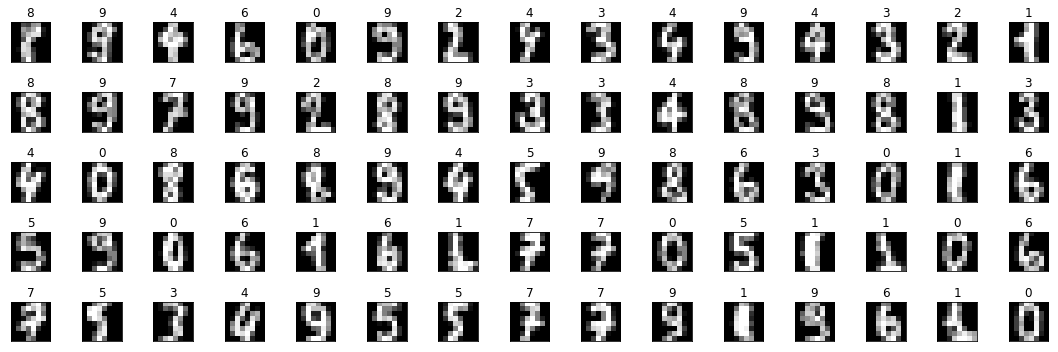

In [19]:
# いくつかのデータに対する手書き数字画像と正解数字
n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D),n_im,replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
k = 0
for i in np.arange(n_im_row):
    for j in np.arange(n_im_col):
        ax = plt.subplot(gs[i,j])
        ax.imshow(X[d_choice[k],:].reshape(n_px_row,n_px_col),cmap='gray')
        ax.set_title(str(yl[d_choice[k]]))
        ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        ax.tick_params(bottom=False,left=False,right=False,top=False)
        k = k + 1

plt.tight_layout()
plt.show()

In [20]:
# データを訓練用とテスト用に分離
testratio = 0.5
D_test = np.around(testratio * D).astype('int')
D_train = D - D_test
d = np.arange(D)
d_test = np.random.choice(d,D_test,replace=False)
d_train = np.setdiff1d(d,d_test,assume_unique=True)
X_test = X[d_test,:]
X_train = X[d_train,:]
yl_test = yl[d_test]
yl_train = yl[d_train]
print('訓練データ数：D_train =',D_train)
print('テストデータ数：D_test =',D_test)

訓練データ数：D_train = 899
テストデータ数：D_test = 898


In [21]:
# ターゲットのラベルから1-hot表現への変換
def label2onehot(yl,C):
    D = yl.size
    d = np.arange(D)
    Y = np.zeros((D,C))
    Y[d,yl] = 1
    return(Y)

In [22]:
# ターゲットの1-hot表現
C = 10 # クラス数（0から9までの10クラス）
Y_train = label2onehot(yl_train,C)
Y_test = label2onehot(yl_test,C)

In [23]:
# 各層のサイズ
n1 = 16
n_lst = [n,n1,C]

### 活性化関数の設定とパラメータの初期化

In [24]:
# ランダムな初期重みベクトル
def randInitWeightVec(n_lst):
    L = len(n_lst) - 1
    Theta_lst = []
    for l in range(L):
        n_l = n_lst[l]
        n_lp1 = n_lst[l+1]
        interval = np.sqrt(6 / (n_l + n_lp1))
        Theta_l = interval * (2 * np.random.rand(n_l+1,n_lp1) - 1)
        Theta_lst.append(Theta_l)
    Theta_vec = mats2vec(Theta_lst)
    return(Theta_vec)

In [25]:
# 初期重みの設定
Thetai_vec = randInitWeightVec(n_lst)

# 正則化パラメータの設定
mu = 1
Mu_vec = mu * np.ones(Thetai_vec.shape)

### 勾配確認

数値微分によりコスト関数の勾配を求め，誤差逆伝播法で求めた値と数値誤差の範囲内で一致することを確認する．

In [26]:
Ji, J_Thetai_vec, vardicti = costFunction_gradient(Thetai_vec,n_lst,X_train,Y_train)

In [27]:
# 数値勾配
def numericalGradient(fun,x):
    epsilon = 1e-4
    f_x = np.zeros(x.shape)
    for i in np.arange(x.size):
        xp = x.copy()
        xp[i] += 0.5 * epsilon
        xm = x.copy()
        xm[i] -= 0.5 * epsilon
        f_x[i] = (fun(xp) - fun(xm)) / epsilon
    return(f_x)

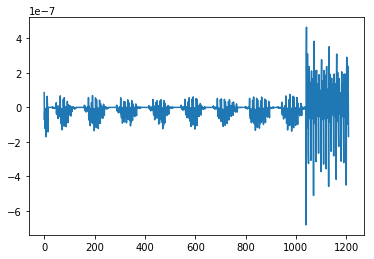

In [28]:
# 学習された重みの値に対する数値勾配の計算
J_Thetai_vec_num = numericalGradient(lambda Theta_vec:costFunction_gradient(Theta_vec,n_lst,X_train,Y_train,propdir='f')[0],Thetai_vec)

# 数値勾配と誤差逆伝播法で求めた勾配の差を成分のインデックスの関数としてプロット
plt.plot(J_Thetai_vec_num - J_Thetai_vec)

### 勾配法と自然勾配法の実行

訓練データに対する正解率： 0.9555061179087876
テストデータに対する正解率： 0.9398663697104677


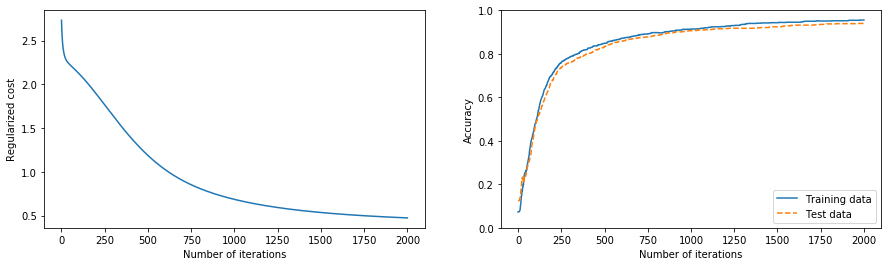

In [29]:
# 正則化あり勾配法の実行
Theta_vec, Jr_history, acc_train_history, acc_test_history, ypl_train, ypl_test = gradientDescentReg(Thetai_vec,Mu_vec,n_lst,
                                                                                X_train,Y_train,X_test,Y_test,alpha=0.1,num_iters=2000)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストのプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(Jr_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

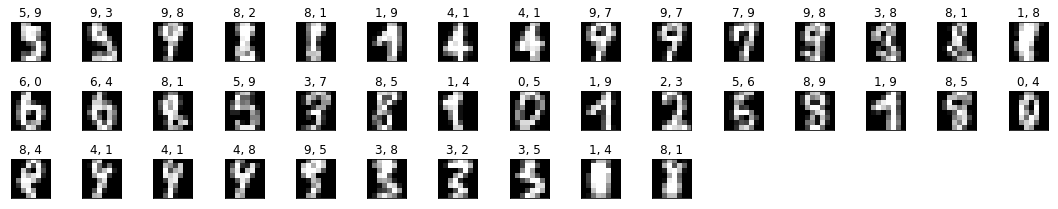

In [30]:
# 予測が外れたすべての訓練データに対する手書き数字画像と正解数字，予測数字
I_incorrect = (ypl_train != yl_train)
d = np.arange(D_train)[I_incorrect]
n_im = np.sum(I_incorrect)
n_im_col = 15
n_im_row = np.ceil(n_im/n_im_col).astype('int')

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
for k in np.arange(n_im):
    i, j = divmod(k,n_im_col)
    ax = plt.subplot(gs[i,j])
    ax.imshow(X_train[d[k],:].reshape(n_px_row,n_px_col),cmap='gray')
    ax.set_title(str(yl_train[d[k]]) + ', ' + str(ypl_train[d[k]]))
    ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    ax.tick_params(bottom=False,left=False,right=False,top=False)

plt.tight_layout()
plt.show()

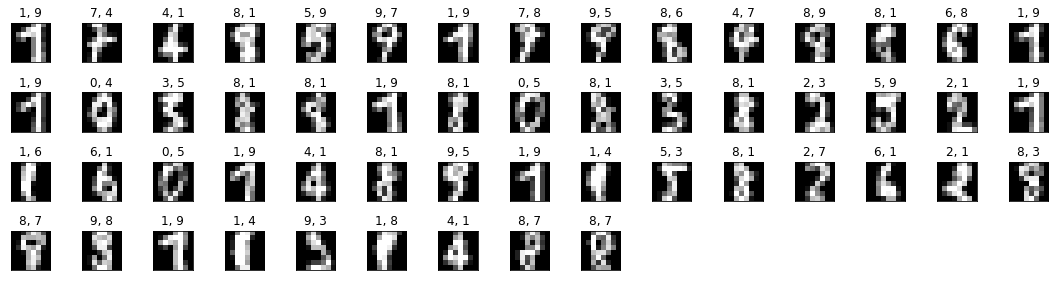

In [31]:
# 予測が外れたすべてのテストデータに対する手書き数字画像と正解数字，予測数字
I_incorrect = (ypl_test != yl_test)
d = np.arange(D_test)[I_incorrect]
n_im = np.sum(I_incorrect)
n_im_col = 15
n_im_row = np.ceil(n_im/n_im_col).astype('int')

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
for k in np.arange(n_im):
    i, j = divmod(k,n_im_col)
    ax = plt.subplot(gs[i,j])
    ax.imshow(X_test[d[k],:].reshape(n_px_row,n_px_col),cmap='gray')
    ax.set_title(str(yl_test[d[k]]) + ', ' + str(ypl_test[d[k]]))
    ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    ax.tick_params(bottom=False,left=False,right=False,top=False)

plt.tight_layout()
plt.show()

訓練データに対する正解率： 0.9899888765294772
テストデータに対する正解率： 0.965478841870824


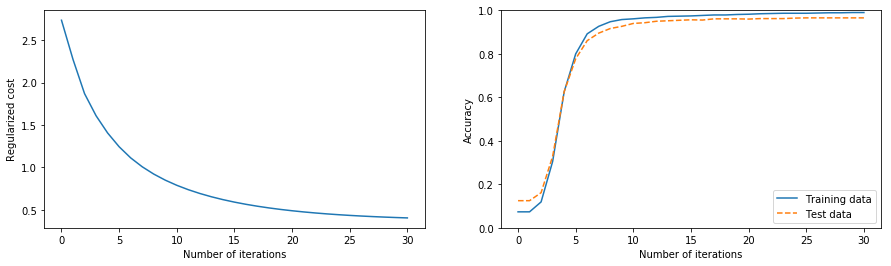

In [32]:
# 正則化あり自然勾配法の実行
Theta_vec, Jr_history, acc_train_history, acc_test_history, ypl_train, ypl_test = naturalGradientDescentReg(Thetai_vec,Mu_vec,n_lst,
                                                                                       X_train,Y_train,X_test,Y_test,alpha=0.1,num_iters=30)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストのプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(Jr_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

### ReLU関数の使用

In [33]:
# ReLU関数とその導関数
def relu_gradient(z):
    s = np.maximum(z,0)
    s_z = (z > 0).astype('float')
    return(s,s_z)

訓練データに対する正解率： 0.9577308120133482
テストデータに対する正解率： 0.9398663697104677


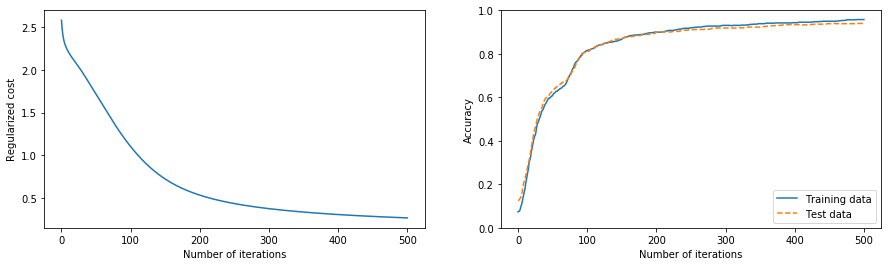

In [34]:
# 正則化あり勾配法の実行
Theta_vec, Jr_history, acc_train_history, acc_test_history, ypl_train, ypl_test = gradientDescentReg(Thetai_vec,Mu_vec,n_lst,
                                                                                X_train,Y_train,X_test,Y_test,phi_hid=relu_gradient,alpha=0.1,num_iters=500)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストのプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(Jr_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

訓練データに対する正解率： 0.9977753058954394
テストデータに対する正解率： 0.9743875278396437


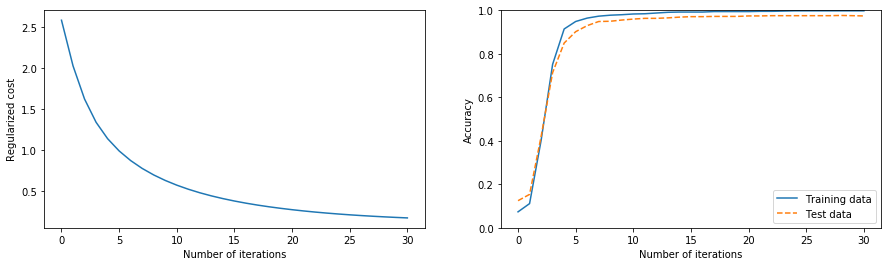

In [35]:
# 正則化あり自然勾配法の実行
Theta_vec, Jr_history, acc_train_history, acc_test_history, ypl_train, ypl_test = naturalGradientDescentReg(Thetai_vec,Mu_vec,n_lst,
                                                                                       X_train,Y_train,X_test,Y_test,phi_hid=relu_gradient,alpha=0.1,num_iters=30)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストのプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(Jr_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()